# Base model for stock prediction

In [1]:
from tools.log_controller import LogController
from pathlib import Path

log_controller = LogController(config_path=Path('config', 'logging_config.json'))
log_controller.start()

In [2]:
from core.data_repository import DataRepository
from pathlib import Path

data_repository = DataRepository(repo_path=Path('repo'))
AMZN_periodic_data = data_repository.get_dataframes()['AMZN']

 2025-10-26 12:17:41 - data_repository - INFO - Loaded: AAPL
 2025-10-26 12:17:41 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-10-26 12:17:41 - data_repository - INFO - Loaded: IBM
 2025-10-26 12:17:41 - data_repository - INFO - Loaded: AMZN
 2025-10-26 12:17:41 - data_repository - INFO - Loaded periodic stock market data for: {'AMZN_enhanced', 'IBM', 'AAPL', 'AMZN'}


In [3]:
from core.data_preparator import DataPreparator
AMZN_supervised_data = DataPreparator.reformat_periodic_to_supervised_data(
    dataframe=AMZN_periodic_data,
    target_column='Close',
    t=3
)

 2025-10-26 12:17:42 - data_preparator - INFO - Preparing data for target column: Close, with t=3


In [4]:
from core.dataset import StockDataset
from sklearn.model_selection import train_test_split
import pandas as pd

AMZN_train_dataset, AMZN_test_dataset = train_test_split(AMZN_supervised_data, test_size=.1, shuffle=False, random_state=42)
AMZN_train_dataset, AMZN_validation_dataset = train_test_split(AMZN_train_dataset, test_size=.2, shuffle=False, random_state=42)

In [5]:
from core.data_preparator import DataPreparator
from sklearn.preprocessing import MinMaxScaler


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

AMZN_train_dataset, AMZN_validation_dataset, AMZN_test_dataset = DataPreparator.scale_datasets(
    train_dataset=AMZN_train_dataset,
    validation_dataset=AMZN_validation_dataset,
    test_dataset=AMZN_test_dataset,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    target_column='Close'
)

 2025-10-26 12:17:46 - data_preparator - INFO - Scaling datasets for target column: Close


In [6]:
AMZN_train_dataset = StockDataset(AMZN_train_dataset)
AMZN_validation_dataset = StockDataset(AMZN_validation_dataset)
AMZN_test_dataset = StockDataset(AMZN_test_dataset)

 2025-10-26 12:17:46 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-26 12:17:46 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-26 12:17:46 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close


In [7]:
# from models.lstm_model import LSTMStockModel

# best_params, best_value = LSTMStockModel.optimize_hyperparameters(
#     train_dataset=AMZN_train_dataset,
#     validation_dataset=AMZN_validation_dataset,
#     feature_number=timesteps_lookback,
#     ticker='AMZN',
#     input_dim=1,
#     output_dim=1,
#     n_trials=20
# )
# print(f'Best hyperparameters: {best_params}, Best MSE Loss: {best_value}')

In [8]:
from models.lstm_model import LSTMStockModel

AMZN_base_model = LSTMStockModel(
    id='base_amzn_model',
    ticker='AMZN',
    input_dim=1,
    hidden_dim=27,
    layer_dim=1,
    output_dim=1
)

 2025-10-26 12:17:46 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=27,
layer_dimension=1,
output_dimension=1)


/home/emdablju/Documents/projects/kalman_stock_prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from torch.optim import Adam
from torch.nn import MSELoss

optimizer = Adam(AMZN_base_model.parameters(), lr=0.001)
loss_function = MSELoss()

In [10]:
from torch.utils.data import DataLoader

AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)
AMZN_validation_data_loader = DataLoader(AMZN_validation_dataset, batch_size=10, shuffle=False)
epochs = 20
feature_number = AMZN_train_dataset.X.shape[1]

train_mse_list, val_mse_list, train_r2_list, val_r2_list, val_actuals, val_predictions, val_errors = AMZN_base_model.perform_training(
    train_loader=AMZN_train_data_loader,
    validation_loader=AMZN_validation_data_loader,
    optimizer=optimizer,
    loss_function=loss_function,
    epochs=epochs,
    feature_number=feature_number
)

 2025-10-26 12:17:48 - model - INFO - Epoch [1/20]
 2025-10-26 12:17:48 - model - INFO - Train MSE: 0.103248, R2: -0.5717
 2025-10-26 12:17:48 - model - INFO - Validation MSE: 0.450250, R2: -15.6109
 2025-10-26 12:17:48 - model - INFO - Epoch [2/20]
 2025-10-26 12:17:48 - model - INFO - Train MSE: 0.066132, R2: -0.0067
 2025-10-26 12:17:48 - model - INFO - Validation MSE: 0.275025, R2: -9.1464
 2025-10-26 12:17:48 - model - INFO - Epoch [3/20]
 2025-10-26 12:17:48 - model - INFO - Train MSE: 0.062252, R2: 0.0523
 2025-10-26 12:17:48 - model - INFO - Validation MSE: 0.217907, R2: -7.0392
 2025-10-26 12:17:48 - model - INFO - Epoch [4/20]
 2025-10-26 12:17:48 - model - INFO - Train MSE: 0.052010, R2: 0.2083
 2025-10-26 12:17:48 - model - INFO - Validation MSE: 0.156946, R2: -4.7901
 2025-10-26 12:17:48 - model - INFO - Epoch [5/20]
 2025-10-26 12:17:48 - model - INFO - Train MSE: 0.040794, R2: 0.3790
 2025-10-26 12:17:48 - model - INFO - Validation MSE: 0.087721, R2: -2.2363
 2025-10-26 

In [11]:
AMZN_test_data_loader = DataLoader(AMZN_test_dataset, batch_size=10, shuffle=False)
feature_number = AMZN_test_dataset.X.shape[1]

actuals, predictions, errors = AMZN_base_model.evaluate(
    test_loader=AMZN_test_data_loader,
    loss_function=loss_function,
    scaler_y=scaler_y,
    feature_number=feature_number
)

Test RMSE: 0.0543
Test Loss (RMSE) on original scale: 6.3377


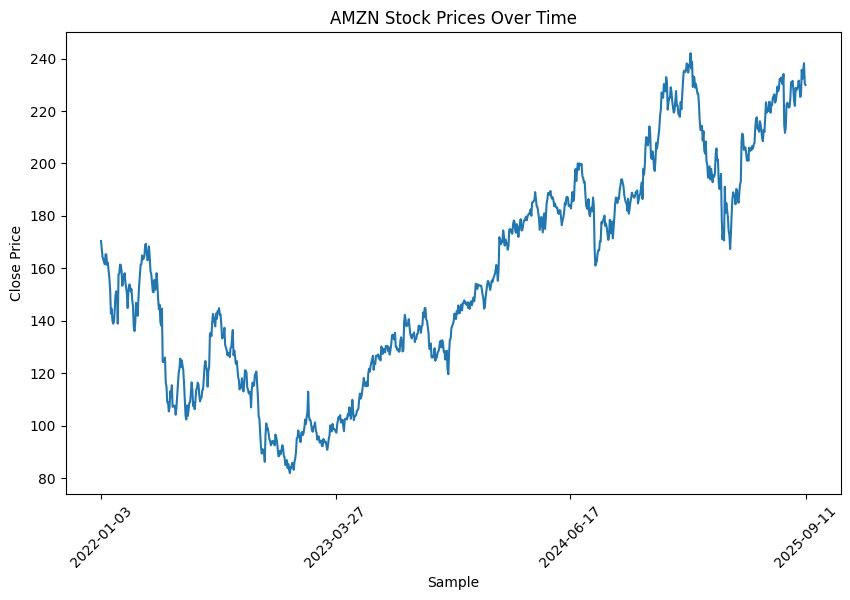

In [12]:
from tools.data_visualizer import plot_stock_prices
plot_stock_prices(AMZN_periodic_data, column='Close', title='AMZN Stock Prices Over Time')

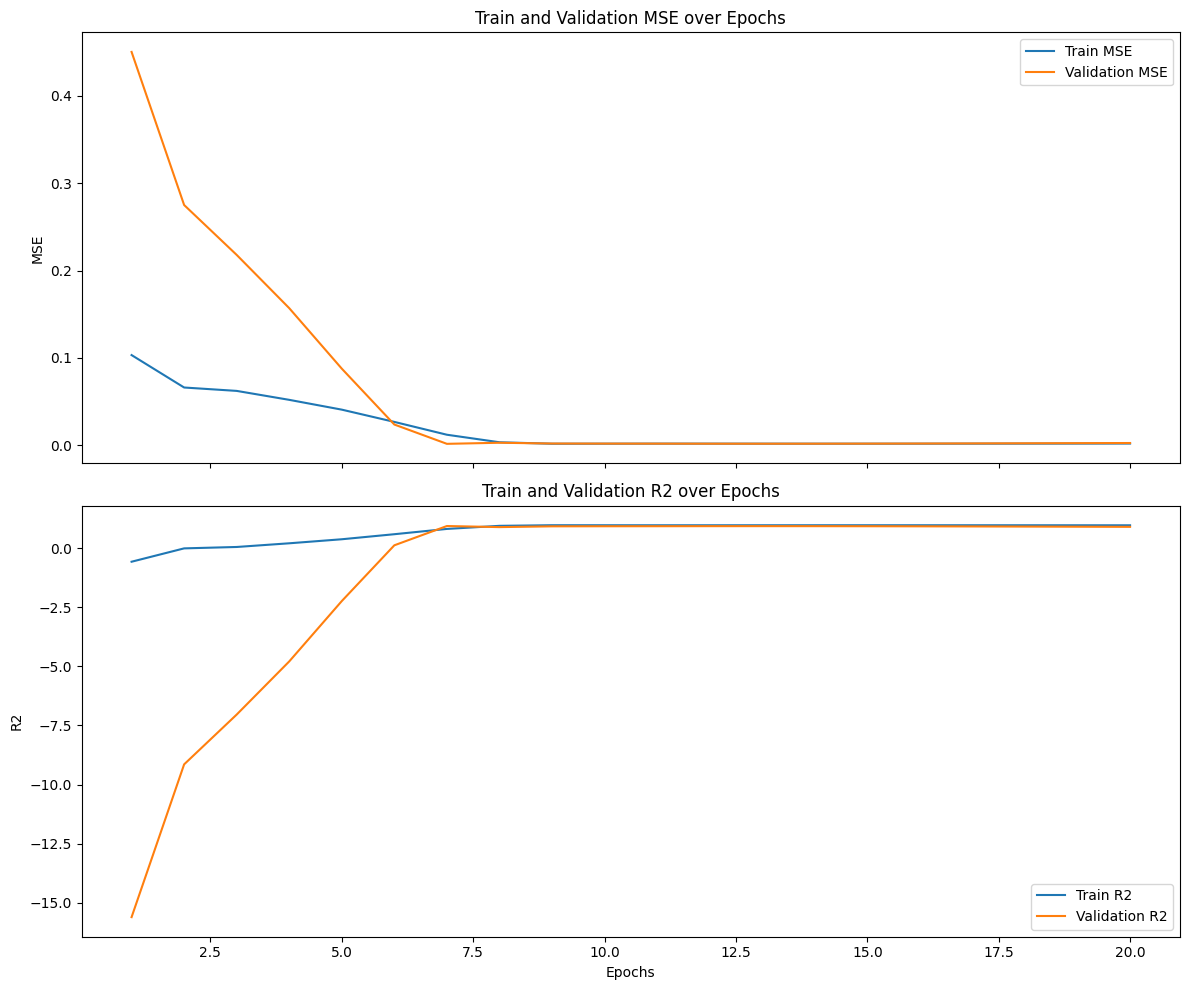

In [13]:
from tools.data_visualizer import plot_performance_metrics
plot_performance_metrics(train_mse_list, val_mse_list, train_r2_list, val_r2_list, epochs)

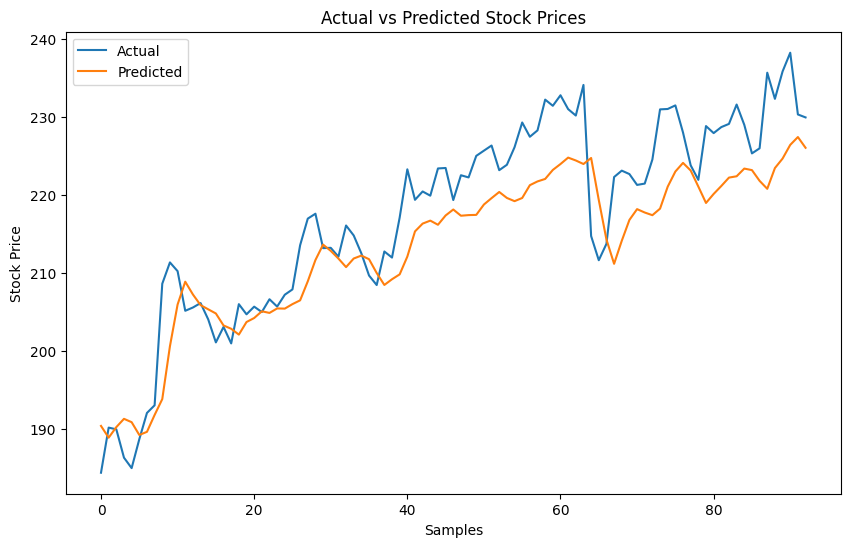

In [14]:
from tools.data_visualizer import plot_predictions

plot_predictions(actuals, predictions)

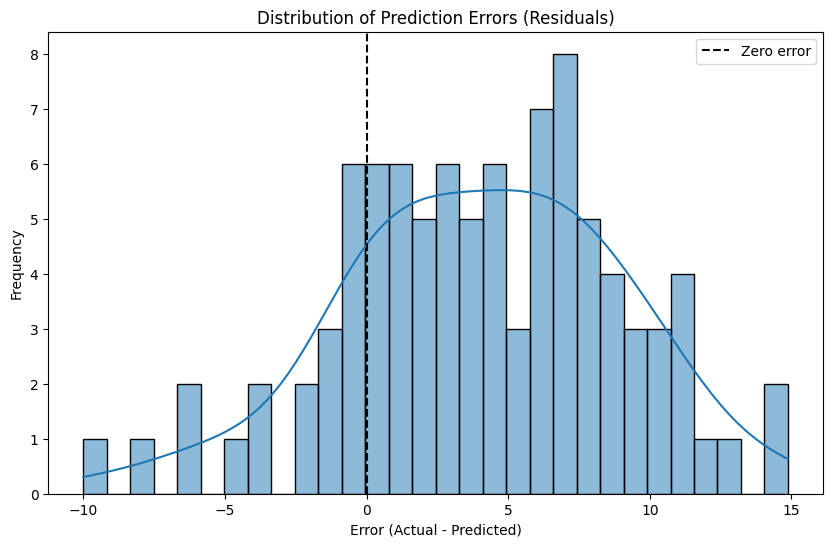

In [15]:
from tools.data_visualizer import plot_errors

plot_errors(errors)